In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
project_path = '/content/drive/MyDrive/BLG454EProject'
os.chdir(project_path)

!ls

cifar10_train_eval.ipynb  fashion_train_eval.ipynb
distiller		  mnist_train_eval.ipynb


This notebook compares how well a simple **LeNet** model performs when trained on:
1. The **full** MNIST training set (60 k images)
2. A **randomly‑sampled** subset containing **10 images per class** (100 images total)
3. A **distilled** synthetic set generated with Gradient Matching

We evaluate each model on the **canonical MNIST test split (10 k images)** and summarise the results.


In [3]:
import os, random, math, time, copy
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from distiller.models.LeNet import LeNet

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cuda


In [4]:
def train(model, loader, criterion, optimizer, epochs=5, log_interval=100):
    model.train()
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(loader, 1):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if batch_idx % log_interval == 0 or batch_idx == len(loader):
                print(f'Epoch {epoch}/{epochs} | Batch {batch_idx}/{len(loader)} | Loss: {running_loss / batch_idx:.4f}', end='\r')
        print(f'Epoch {epoch} finished. Avg Loss: {running_loss / len(loader):.4f}')

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    return 100.0 * correct / total


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

root = Path('distiller/data')
full_train = datasets.MNIST(root, train=True, download=True, transform=transform)
test_set = datasets.MNIST(root, train=False, download=True, transform=transform)

test_loader = DataLoader(test_set, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)

print(f'Full training set size: {len(full_train)}')

Full training set size: 60000


## Training on the **full** MNIST training set

In [6]:
BATCH_SIZE_FULL = 128
EPOCHS_FULL = 1

full_loader = DataLoader(full_train, batch_size=BATCH_SIZE_FULL, shuffle=True, num_workers=2, pin_memory=True)

model_full = LeNet().to(device)
optimizer = optim.Adam(model_full.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train(model_full, full_loader, criterion, optimizer, epochs=EPOCHS_FULL, log_interval=200)
acc_full = evaluate(model_full, test_loader)
print(f'\nTest accuracy (full data): {acc_full:.2f}%')

Epoch 1 finished. Avg Loss: 0.3011

Test accuracy (full data): 97.00%


## Training on a **random** subset (10 images × 10 classes = 100 images)

In [12]:
def stratified_random_subset(dataset, per_class=10):
    targets = np.array(dataset.targets)
    indices = []
    for cls in range(10):
        cls_idx = np.where(targets == cls)[0]
        indices.extend(np.random.choice(cls_idx, per_class, replace=False))
    return indices

subset_indices = stratified_random_subset(full_train, per_class=10)
small_train = Subset(full_train, subset_indices)
print('Subset size:', len(small_train))

BATCH_SIZE_SMALL = 32
EPOCHS_SMALL = 30  # More epochs because dataset is tiny

small_loader = DataLoader(small_train, batch_size=BATCH_SIZE_SMALL, shuffle=True, num_workers=2, pin_memory=True)

model_small = LeNet().to(device)
optimizer_small = optim.Adam(model_small.parameters(), lr=1e-3)
criterion_small = nn.CrossEntropyLoss()

train(model_small, small_loader, criterion_small, optimizer_small, epochs=EPOCHS_SMALL, log_interval=1)
acc_small = evaluate(model_small, test_loader)
print(f'\nTest accuracy (random 100 examples): {acc_small:.2f}%')

Subset size: 100
Epoch 1 finished. Avg Loss: 2.2823
Epoch 2 finished. Avg Loss: 2.2360
Epoch 3 finished. Avg Loss: 2.1785
Epoch 4 finished. Avg Loss: 2.1191
Epoch 5 finished. Avg Loss: 1.9601
Epoch 6 finished. Avg Loss: 1.8343
Epoch 7 finished. Avg Loss: 1.6432
Epoch 8 finished. Avg Loss: 1.4877
Epoch 9 finished. Avg Loss: 1.3013
Epoch 10 finished. Avg Loss: 1.0846
Epoch 11 finished. Avg Loss: 0.9049
Epoch 12 finished. Avg Loss: 0.6701
Epoch 13 finished. Avg Loss: 0.6481
Epoch 14 finished. Avg Loss: 0.5000
Epoch 15 finished. Avg Loss: 0.4231
Epoch 16 finished. Avg Loss: 0.5859
Epoch 17 finished. Avg Loss: 0.4004
Epoch 18 finished. Avg Loss: 0.2917
Epoch 19 finished. Avg Loss: 0.2355
Epoch 20 finished. Avg Loss: 0.2816
Epoch 21 finished. Avg Loss: 0.2421
Epoch 22 finished. Avg Loss: 0.1473
Epoch 23 finished. Avg Loss: 0.1507
Epoch 24 finished. Avg Loss: 0.1070
Epoch 25 finished. Avg Loss: 0.1338
Epoch 26 finished. Avg Loss: 0.1013
Epoch 27 finished. Avg Loss: 0.0707
Epoch 28 finished. A

## Training on the **distilled synthetic** set

In [10]:
SYNSET_PATH = 'distiller/syndata/MNIST_LeNet_ipc-10_exp-0.pt'

assert Path(SYNSET_PATH).exists(), (
    f'Distilled file not found at {SYNSET_PATH}. ' \
    'Upload it to the Colab session or place it in the working directory.'
)

checkpoint = torch.load(SYNSET_PATH, map_location='cpu')

# Expected keys: images (n, 1, 28, 28) tensor, labels (n) tensor
synthetic_images = checkpoint.get('syn_imgs') if isinstance(checkpoint, dict) else checkpoint[0]
synthetic_labels = checkpoint.get('syn_labels') if isinstance(checkpoint, dict) else checkpoint[1]

print('Synthetic set shape:', synthetic_images.shape)

distill_ds = TensorDataset(synthetic_images, synthetic_labels)
BATCH_SIZE_DISTILL = 32
EPOCHS_DISTILL = 300

distill_loader = DataLoader(distill_ds, batch_size=BATCH_SIZE_DISTILL, shuffle=True)

model_distill = LeNet().to(device)
optimizer_distill = optim.Adam(model_distill.parameters(), lr=1e-3)
criterion_distill = nn.CrossEntropyLoss()

train(model_distill, distill_loader, criterion_distill, optimizer_distill, epochs=EPOCHS_DISTILL, log_interval=1)
acc_distill = evaluate(model_distill, test_loader)
print(f'\nTest accuracy (distilled set): {acc_distill:.2f}%')

Synthetic set shape: torch.Size([100, 1, 28, 28])
Epoch 1 finished. Avg Loss: 2.3389
Epoch 2 finished. Avg Loss: 2.2618
Epoch 3 finished. Avg Loss: 2.2229
Epoch 4 finished. Avg Loss: 2.1756
Epoch 5 finished. Avg Loss: 2.1383
Epoch 6 finished. Avg Loss: 2.0018
Epoch 7 finished. Avg Loss: 1.8174
Epoch 8 finished. Avg Loss: 1.5837
Epoch 9 finished. Avg Loss: 1.2059
Epoch 10 finished. Avg Loss: 0.9204
Epoch 11 finished. Avg Loss: 0.7181
Epoch 12 finished. Avg Loss: 0.5227
Epoch 13 finished. Avg Loss: 0.2963
Epoch 14 finished. Avg Loss: 0.1827
Epoch 15 finished. Avg Loss: 0.1325
Epoch 16 finished. Avg Loss: 0.0700
Epoch 17 finished. Avg Loss: 0.0557
Epoch 18 finished. Avg Loss: 0.0308
Epoch 19 finished. Avg Loss: 0.0271
Epoch 20 finished. Avg Loss: 0.0279
Epoch 21 finished. Avg Loss: 0.0165
Epoch 22 finished. Avg Loss: 0.0121
Epoch 23 finished. Avg Loss: 0.0111
Epoch 24 finished. Avg Loss: 0.0073
Epoch 25 finished. Avg Loss: 0.0094
Epoch 26 finished. Avg Loss: 0.0059
Epoch 27 finished. Avg 

## Result Summary

Full Data   : 97.00%
Random 100  : 78.31%
Distilled Set: 81.91%


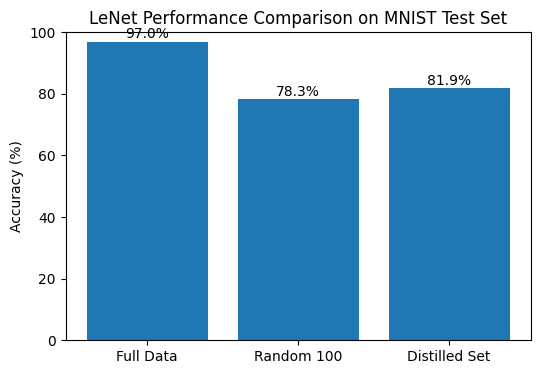

In [13]:
results = {
    'Full Data': acc_full,
    'Random 100': acc_small,
    'Distilled Set': acc_distill,
}

for k, v in results.items():
    print(f'{k:<12}: {v:5.2f}%')

# Bar chart
plt.figure(figsize=(6,4))
plt.bar(results.keys(), results.values())
plt.ylabel('Accuracy (%)')
plt.title('LeNet Performance Comparison on MNIST Test Set')
plt.ylim(0, 100)
for i, v in enumerate(results.values()):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center')
plt.show()
